In [1]:
#%%capture
!pip install yfinance==0.2.58
#!pip install yfinance
#!pip install twelvedata
import numpy as np
import pandas as pd
import yfinance as yf
!pip show yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.64
    Uninstalling yfinance-0.2.64:
      Successfully uninstalled yfinance-0.2.64
Name: yfinance
Version: 0.2.58
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: beautifulsoup4, curl_cffi, frozendict, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests
Required-by: 


In [34]:
ticker = "1030.SR"
data = yf.download(ticker, start="2022-01-01", end="2025-06-23")
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,1030.SR,1030.SR,1030.SR,1030.SR,1030.SR
Date,,,,,
2022-01-02,10.213531,10.234269,10.140947,10.172054,639613
2022-01-03,10.306851,10.369066,10.244637,10.244637,2457787
2022-01-04,10.358698,10.410543,10.306852,10.306852,1773631
2022-01-05,10.566079,10.586817,10.317221,10.379436,1725451
2022-01-06,10.711246,10.721615,10.503864,10.576447,1713834
...,...,...,...,...,...
2025-06-16,14.380000,14.540000,14.360000,14.380000,379075
2025-06-17,14.140000,14.380000,14.100000,14.380000,623036


In [35]:
# Find the lowest price for the stock over the last week
data["prv_low_1"] = data["Low"].shift(1)
data["prv_low_2"] = data["Low"].shift(2)
data["prv_low_3"] = data["Low"].shift(3)
data["prv_low_4"] = data["Low"].shift(4)
data["prv_low_5"] = data["Low"].shift(5)
data["Low_Last_5d"] = data[["prv_low_1", "prv_low_2","prv_low_3","prv_low_4","prv_low_5"]].values.min(1)
data = data.drop(["prv_low_1", "prv_low_2", "prv_low_3", "prv_low_4", "prv_low_5"], axis=1)

# Find the highest price for the stock over the last week
data['prv_high_1'] = data["High"].shift(1)
data['prv_high_2'] = data["High"].shift(2)
data['prv_high_3'] = data["High"].shift(3)
data['prv_high_4'] = data["High"].shift(4)
data['prv_high_5'] = data["High"].shift(5)
data["High_Last_5d"] = data[["prv_high_1", "prv_high_2","prv_high_3","prv_high_4","prv_high_5"]].values.max(1)
data = data.drop(["prv_high_1", "prv_high_2", "prv_high_3", "prv_high_4", "prv_high_5"], axis=1)
data.tail(2)

Price,Close,High,Low,Open,Volume,Low_Last_5d,High_Last_5d
Ticker,1030.SR,1030.SR,1030.SR,1030.SR,1030.SR,,
Date,,,,,,,
2025-06-19,14.10,14.12,13.96,14.12,844807,14.00,14.68
2025-06-22,14.02,14.18,13.98,14.00,138543,13.96,14.54


In [36]:
# Create boolean variable marking whether stock dropped at least six percent in the last week (five days)
data["six_percent_of_close_price"] = .94*data["Close"]
data["Close"] = 1*data["Close"]
data["six_percent_of_close_price_within_last_five_days"] = np.where((data['Low_Last_5d'] <= data['six_percent_of_close_price']) & (data['six_percent_of_close_price'] <= data['High_Last_5d']), True, False)

In [37]:
# Create boolean variable marking whether current close price is greater than yesterdays close price
data["Last_Close"] = data["Close"].shift(1)
data["close_diff"] = data["Close"].values.reshape(data.shape[0]) - data["Last_Close"].values.reshape(data.shape[0])
data["up_from_yesterday"] = np.where((data["close_diff"] > 0), True, False)
data.tail(5)

Price,Close,High,Low,Open,Volume,Low_Last_5d,High_Last_5d,six_percent_of_close_price,six_percent_of_close_price_within_last_five_days,Last_Close,close_diff,up_from_yesterday
Ticker,1030.SR,1030.SR,1030.SR,1030.SR,1030.SR,,,,,,,
Date,,,,,,,,,,,,
2025-06-16,14.38,14.54,14.36,14.38,379075,14.00,14.80,13.5172,False,14.38,0.00,False
2025-06-17,14.14,14.38,14.10,14.38,623036,14.00,14.80,13.2916,False,14.38,-0.24,False
2025-06-18,14.12,14.14,14.00,14.14,135071,14.00,14.80,13.2728,False,14.14,-0.02,False
2025-06-19,14.10,14.12,13.96,14.12,844807,14.00,14.68,13.2540,False,14.12,-0.02,False
2025-06-22,14.02,14.18,13.98,14.00,138543,13.96,14.54,13.1788,False,14.10,-0.08,False


In [38]:
# Buy stock if price dropped at least seven percent in last week and current close price is greater than yesterdays close price
data["shortsell"] = data["six_percent_of_close_price_within_last_five_days"] & data["up_from_yesterday"]
data["shortsellcumsum"] = data["shortsell"].cumsum().astype('int64')
data = data.drop(["Last_Close","close_diff","six_percent_of_close_price","up_from_yesterday","six_percent_of_close_price_within_last_five_days","Low_Last_5d","High_Last_5d"], axis=1)

# Add numerical columns of stocks current close price increased and decrease by one percent for final analysis
data["Close_up1%"] = 1.01*data["Close"]
data["Close_down1%"] = .99*data["Close"]
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1030.SR,1030.SR,1030.SR,1030.SR,1030.SR,,,,
Date,,,,,,,,,
2025-06-03,14.56,14.74,14.56,14.68,643042,False,42,14.7056,14.4144
2025-06-04,14.44,14.76,14.44,14.64,985047,False,42,14.5844,14.2956
2025-06-11,14.70,14.80,14.44,14.44,456198,False,42,14.8470,14.5530
2025-06-12,14.68,14.68,14.38,14.68,706636,False,42,14.8268,14.5332
2025-06-15,14.38,14.38,14.00,14.00,471743,False,42,14.5238,14.2362
2025-06-16,14.38,14.54,14.36,14.38,379075,False,42,14.5238,14.2362
2025-06-17,14.14,14.38,14.10,14.38,623036,False,42,14.2814,13.9986
2025-06-18,14.12,14.14,14.00,14.14,135071,False,42,14.2612,13.9788


In [39]:
# view dates where we buy the stock + the two days after
#buyclause = data['buy']==True
#view = data[buyclause.shift(2)|buyclause.shift()|buyclause]
#view

In [40]:
data.loc[(data.shortsell == False), 'Close_up1%'] = np.nan
data.loc[(data.shortsell == False), 'Close_down1%'] = np.nan
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1030.SR,1030.SR,1030.SR,1030.SR,1030.SR,,,,
Date,,,,,,,,,
2025-06-03,14.56,14.74,14.56,14.68,643042,False,42,NaN,NaN
2025-06-04,14.44,14.76,14.44,14.64,985047,False,42,NaN,NaN
2025-06-11,14.70,14.80,14.44,14.44,456198,False,42,NaN,NaN
2025-06-12,14.68,14.68,14.38,14.68,706636,False,42,NaN,NaN
2025-06-15,14.38,14.38,14.00,14.00,471743,False,42,NaN,NaN
2025-06-16,14.38,14.54,14.36,14.38,379075,False,42,NaN,NaN
2025-06-17,14.14,14.38,14.10,14.38,623036,False,42,NaN,NaN
2025-06-18,14.12,14.14,14.00,14.14,135071,False,42,NaN,NaN


In [41]:
data["Close_up1%"] = data["Close_up1%"].ffill()
data["Close_down1%"] = data["Close_down1%"].ffill()
data.tail(10)

Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%
Ticker,1030.SR,1030.SR,1030.SR,1030.SR,1030.SR,,,,
Date,,,,,,,,,
2025-06-03,14.56,14.74,14.56,14.68,643042,False,42,14.8268,14.5332
2025-06-04,14.44,14.76,14.44,14.64,985047,False,42,14.8268,14.5332
2025-06-11,14.70,14.80,14.44,14.44,456198,False,42,14.8268,14.5332
2025-06-12,14.68,14.68,14.38,14.68,706636,False,42,14.8268,14.5332
2025-06-15,14.38,14.38,14.00,14.00,471743,False,42,14.8268,14.5332
2025-06-16,14.38,14.54,14.36,14.38,379075,False,42,14.8268,14.5332
2025-06-17,14.14,14.38,14.10,14.38,623036,False,42,14.8268,14.5332
2025-06-18,14.12,14.14,14.00,14.14,135071,False,42,14.8268,14.5332


In [42]:
data["buyup"] = np.where((data["Close"].values.reshape(data.shape[0])-data["Close_up1%"].values.reshape(data.shape[0]) > 0),True,False)
data["buydown"] = np.where((data["Close_down1%"].values.reshape(data.shape[0])-data["Close"].values.reshape(data.shape[0]) > 0),True,False)
data["buy"] = data["buydown"]|data["buyup"]
data["buycumsum"] = data["buy"].cumsum().astype('int64')
#data.to_csv('out.csv', index=False)
#data = pd.read_csv('out.csv')
#data.tail(10)

In [43]:
data.to_csv("out.csv")
data = pd.read_csv("out.csv")
data.head(10)

,Price,Close,High,Low,Open,Volume,shortsell,shortsellcumsum,Close_up1%,Close_down1%,buyup,buydown,buy,buycumsum
0,Ticker,1030.SR,1030.SR,1030.SR,1030.SR,1030.SR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-02,10.213530540466309,10.234268578193866,10.140946584566455,10.172054465011191,639613,False,0.0,NaN,NaN,False,False,False,0.0
3,2022-01-03,10.306851387023926,10.369066322108978,10.244637275792245,10.244637275792245,2457787,False,0.0,NaN,NaN,False,False,False,0.0
4,2022-01-04,10.358697891235352,10.410542986869672,10.306851971747614,10.306851971747614,1773631,False,0.0,NaN,NaN,False,False,False,0.0
5,2022-01-05,10.566079139709473,10.586817178045798,10.31722103196673,10.379435970829126,1725451,False,0.0,NaN,NaN,False,False,False,0.0
6,2022-01-06,10.7112455368042,10.721614555299459,10.503863519192292,10.57644747251247,1713834,False,0.0,NaN,NaN,False,False,False,0.0
7,2022-01-09,10.887520790100098,10.918627848771639,10.731984672888938,10.731984672888938,1763464,True,1.0,10.996396,10.778646,False,False,False,0.0
8,2022-01-10,11.011947631835938,11.136376674635972,10.89788843113481,11.022316650081494,2491978,True,2.0,11.122067,10.901828,False,False,False,0.0
9,2022-01-11,11.39560317993164,11.39560317993164,10.99120981265292,11.011947849554048,2501456,True,3.0,11.509559,11.281647,False,False,False,0.0


In [44]:
entry_exit_values = []
dates = []
for x in range(1,int(data["shortsellcumsum"].max())+1):
  frame = data.loc[data.shortsellcumsum==x]
  if (frame.loc[frame.buy==True].shape[0]>=1):
    ssclose = float(frame.loc[frame.shortsell==True]["Close"].to_list()[0])
    buyclose = float(frame.loc[frame.buy==True]["Close"].to_list()[0])
    entry_exit_values.append(ssclose-buyclose)
    dates.append(frame.loc[frame.buy==True]["Price"].to_list()[0])

In [45]:
entry_exit_values

[0.19701290130615234,
 0.2626180648803711,
 0.2626152038574219,
 0.22115039825439453,
 0.2764415740966797,
 0.8154983520507812,
 0.40083789825439453,
 -0.165863037109375,
 0.3455486297607422,
 0.1520395278930664,
 -0.2254009246826172,
 0.12621688842773438,
 0.22438907623291016,
 0.1402416229248047,
 0.14380359649658203,
 0.24597930908203125,
 0.37006473541259766,
 0.1752948760986328,
 0.2200002670288086,
 0.20000076293945312]

In [46]:
def cumlative_pnl(entry_exit_values):
  cumpnl = 0
  pnl = []
  for num in entry_exit_values:
    cumpnl += num
    pnl.append(cumpnl)
  return pnl
import datetime as dt
from datetime import datetime

pnl = cumlative_pnl(entry_exit_values=entry_exit_values)
#pnl = [diff*115 for diff in pnl]

date_objects = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [47]:
print(date_objects)
print(pnl)

[datetime.date(2022, 1, 16), datetime.date(2022, 2, 24), datetime.date(2022, 4, 17), datetime.date(2022, 4, 24), datetime.date(2022, 5, 22), datetime.date(2022, 6, 19), datetime.date(2022, 6, 23), datetime.date(2022, 6, 28), datetime.date(2022, 7, 14), datetime.date(2022, 7, 25), datetime.date(2022, 8, 1), datetime.date(2022, 10, 6), datetime.date(2022, 10, 25), datetime.date(2023, 3, 23), datetime.date(2024, 2, 27), datetime.date(2024, 6, 12), datetime.date(2024, 11, 14), datetime.date(2024, 12, 12), datetime.date(2025, 4, 9), datetime.date(2025, 4, 15)]
[0.19701290130615234, 0.45963096618652344, 0.7222461700439453, 0.9433965682983398, 1.2198381423950195, 2.035336494445801, 2.4361743927001953, 2.2703113555908203, 2.6158599853515625, 2.767899513244629, 2.5424985885620117, 2.668715476989746, 2.8931045532226562, 3.033346176147461, 3.177149772644043, 3.423129081726074, 3.793193817138672, 3.9684886932373047, 4.188488960266113, 4.388489723205566]


Text(0, 0.5, 'Cumulative PNL ($)')

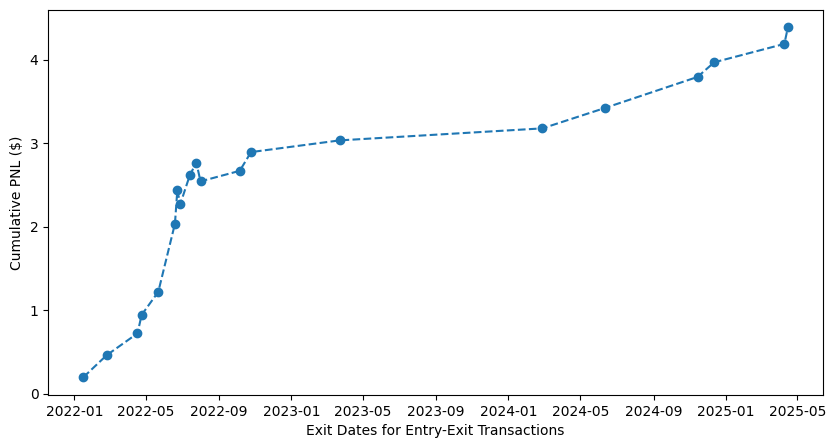

In [48]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(date_objects, pnl,marker='o', linestyle='dashed')
plt.xlabel('Exit Dates for Entry-Exit Transactions')
plt.ylabel('Cumulative PNL ($)')